Playlist names cluster
============
Work in progress notebook
__________

Function for printing progress

In [1]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record, index - 1
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )


Loading data (first 4000 playlists, 40000 tracks)

In [2]:
import pandas as pd
import numpy as np

In [70]:
df_playlist = pd.read_csv('../../data/playlists.csv', sep=';', nrows=4000)
df_playlist.head()

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,duration_ms,num_artists,description
0,Throwbacks,False,0,1493424000,52,47,1,6,11532414,37,NaN
1,Awesome Playlist,False,1,1506556800,39,23,1,5,11656470,21,NaN
2,korean,False,2,1505692800,64,51,1,18,14039958,31,NaN
3,mat,False,3,1501027200,126,107,1,4,28926058,86,NaN
4,90s,False,4,1401667200,17,16,2,7,4335282,16,NaN


In [71]:
df_tracks = pd.read_csv('../../data/tracks.csv', sep=';', nrows=400000)
df_tracks.head()

,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,pid
0,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,0
1,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,0
2,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),0
3,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,0
4,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,0


One hot encoding of presence of a track in the playlist

In [72]:
_unique_pid = np.unique(df_playlist['pid'])
_unique_tracks = np.unique(df_tracks['track_uri'])
matrix = np.zeros((len(_unique_pid), len(_unique_tracks)), np.int)
matrix.shape

(4000, 121298)

In [76]:
for c, index in log_progress(_unique_tracks, every=5, name='distinct tracks'):
    _sub = df_tracks.loc[df_tracks['track_uri'] == c]
    for pid in _sub['pid']:
        if pid < len(_unique_pid):
            matrix[pid, index] = 1

VBox(children=(HTML(value=''), IntProgress(value=0, max=121298)))

Clusterising

In [117]:
X = matrix
Y = df_playlist['name'].values
num_clusters = 40

In [118]:
from sklearn import cluster
import matplotlib.pyplot as plt

model = cluster.AgglomerativeClustering(n_clusters=num_clusters).fit(X, Y)
new_order = np.argsort(model.labels_)

In [119]:
df_playlist.loc[:,'cluster'] = model.labels_
clusterized = df_playlist[['name', 'cluster']].sort_values(['cluster'], ascending=False)

Printing some results

In [120]:
from IPython.core.display import Markdown, display

biggest_cluster = -1
biggest_cluster_dim = -1

for i in np.arange(num_clusters):
    _involved = clusterized.loc[df_playlist['cluster']==i] 
    _dim = _involved.shape[0]
    if _dim > biggest_cluster_dim:
        biggest_cluster_dim = _dim
        biggest_cluster = i
    
    display(Markdown('#### CLUSTER %d' % i))
    display(Markdown('%d playlists' % _dim))
    display(Markdown('`%s`' % '` `'.join(_involved['name'][0:30])))

#### CLUSTER 0

270 playlists

`car rides` `booze cruise` `Eminem` `Hits` `Run` `running 3` `Paisa` `calm` `March` `Party` `Good Vibes` `workout` `My List` `Latino` `My music` `september ` `Electric Love` `Running 2.0` `good good` `fall '17` `ride` `Fun` `Bangerz` `90's music` `Drugs` `SARAH` `Love love` `Stuff` `Gaming` `Volleyball`

#### CLUSTER 1

46 playlists

`weekend` `workout 2` `old songs ` `Guilty pleasure` `throwback` `Gabriel` `Punk` `Dance mix` `throw backs` `Throwbacks` `Happy :)` `scott` `Workout!` `Throwbackkkk` `Maui` `Wedding Dance Party` `throwbacksss` `study!` `Party` `// Drive` `Throwbacks` `old but good` `feel good` `2000s hits` `partay ` `Favorite Songs` `Cinderella` `tb` `Throwbacks` `throwback`

#### CLUSTER 2

2 playlists

`jamzzz` `vibes`

#### CLUSTER 3

9 playlists

`Country` `Country` `Country Favorites` `Tennessee ` `Country` `Country` `My Favorites` `new` `Country`

#### CLUSTER 4

122 playlists

`14` `Fall 16` `Chill Out Music` `alt` `mhm` `Beatles` `jamz` `New Wave` `Light` `happy` `Chill` `YOU` `elevator music` `New stuff` `white girl music` `mmmm//` `Work in progress` `Lounging` `slow` `songs i like` `Feel Good` `Feels` `Paint` `Indie` `Chill ` `Chill Rock` `Shower songs` `Solitude` `carpe diem` `chill out`

#### CLUSTER 5

26 playlists

`party music` `hoco` `bump` `PARTY` `sb2k17` `Pump up` `random` `vibin'` `Jammin'` `dance` `😈😈😈` `PT` `Cinco De Mayo` `NewNew` `getting ready` `lib` `party` `NB` `Clubbin` `rap` `rap mix` `rap` `Rap / hip hop` `pregame` `Rap/Pop` `car`

#### CLUSTER 6

3166 playlists

`deep` `Long drive ` `Rap` `so` `Salsa` `Beyoncé ` `SOUNDTRACKS` `Xmas` `hype` `Jams` `random` `turnt ` `Heavy` `vibez` `Wedding Reception` `You` `Dads playlist` `Current` `oldies but goodies` `Countray` `lit` `Gym Workout` `Fire🔥🔥🔥` `Spring 2016` `joan Sebastian` `go to` `wedding` `Art` `ON REPEAT` `Tunes`

#### CLUSTER 7

52 playlists

`I workout!` `Country` `country` `SB` `Country` `country` `Country favorites` `roadtrip 🚗` `COUNTRY ` `Friday afternoon...` `Work` `MERICA` `Country 1` `Country` `Country Favorites` `Belters` `country 2017` `car rides` `country` `country` `country` `beach` `Country` `band songs ` `Country Lovin` `Country` `country` `country ` `Favorite Country` `country favs`

#### CLUSTER 8

13 playlists

`The Mix` `mar` `feels` `xx` `vibin` `BANGERZ` `unknown` `Straight Fire` `explicit` `mood` `sad boi` `Rap` `KILLA`

#### CLUSTER 9

15 playlists

`Ma` `woo` `Jammin` `90's Hits` `Rock` `Throwbacks` `90s alternative` `nostalgia` `Rock mix` `Teen Angst` `Dancing on my own` `90's ` `90's` `Alternative Rock` `Alternative`

#### CLUSTER 10

13 playlists

`2000s r&b` `HER` `R&B classics ` `breathe` `Main` `Way Back When` `R&B classics` `~Rando~` `Slow jams` `Love Music` `housewarming` `R&B` `in my feels`

#### CLUSTER 11

3 playlists

`New ish` `Party` `BUMP`

#### CLUSTER 12

17 playlists

`Disney` `Disney Jams` `Disney` `disney` `Disney` `Disney` `Musicals` `Disney!` `Girls` `Disney` `Disney` `Musicals` `Disney` `Disney` `three` `Disney` `Tangled`

#### CLUSTER 13

3 playlists

`Jesse` `Drake` `Drake`

#### CLUSTER 14

20 playlists

`❤❤❤` `rap` `everything` `💛💛` `Rap` `Hype` `Litty ` `summer 2k17` `Gym` `music` `2016` `🔥🔥🔥🔥` `wrap` `2k17` `BANGAZ` `music` `My Music` `💯💯💯` `New School` `Its a Trap`

#### CLUSTER 15

49 playlists

`You already know` `abby ` `🖕🏻` `tailgate` `Russ ` `Up` `Bumpin'` `Go to ` `vroom` `IDGAF` `getting ready` `HARDCORE WORKOUT` `New music` `mb` `Trap` `party playlist` `hey` `litty` `Pool` `Slapz` `cole` `pregame` `🔥🔥🔥` `pregame` `SENIOR YEAR` `Aux` `hoco` `RECENT` `LIT!!!!!!!` `Dat new new`

#### CLUSTER 16

6 playlists

`Country` `Country` `Country` `country` `Country` `Country`

#### CLUSTER 17

11 playlists

`Country summer` `Country` `Good Country` `Country` `Country` `country ` `Country` `Country` `country` `country` `Classic Country`

#### CLUSTER 18

2 playlists

`Everything` `Mashup`

#### CLUSTER 19

2 playlists

`Musicales` `Musicals`

#### CLUSTER 20

1 playlists

`Pole`

#### CLUSTER 21

16 playlists

`Lifting ` `Summa` `Summer17` `high` `LIT` `getting ready` `lit` `Summer Party` `summer 2016` `summer playlist` `pg` `summer '17` `hyfr` `basic` `Stuff` `2020`

#### CLUSTER 22

84 playlists

`🤘🏼` `Awesome Playlist` `classic rock` `classics` `Dad Rock` `essentials` `rock` `Music` `take me back` `70/80` `THE MIX` `oldies` `Rock` `Old music` `The Drive` `family` `Alright` `Cruisin` ` Rock.....` `Legendary` `Classic Rock` `old people` `Elisa` `80's` `oldies` `Good Music ` `Oldies` `Old songs` `oldies` `Old School `

#### CLUSTER 23

10 playlists

`Rock` `Gym` `2015` `Beats` `rock` `Driving` `Melting Pot` `death` `Gym Mix` `Kyle`

#### CLUSTER 24

10 playlists

`everything ` `bounce` `Main Playlist` `This Is What You Came For` `HITS` `English ` `ashley` `Life ` `Pop Hits` `w o r k o u t`

#### CLUSTER 25

1 playlists

`2012`

#### CLUSTER 26

1 playlists

`Hood`

#### CLUSTER 27

1 playlists

`Favorite Songs`

#### CLUSTER 28

3 playlists

`Reggae` `Reggae` `Local`

#### CLUSTER 29

4 playlists

`70's` `will` `PARTY ` `Classic`

#### CLUSTER 30

4 playlists

`⚡️⚡️⚡️` `vibes` `( ͡° ͜ʖ ͡°)` `california`

#### CLUSTER 31

1 playlists

`christian`

#### CLUSTER 32

1 playlists

`driving music `

#### CLUSTER 33

1 playlists

`Good Vibes`

#### CLUSTER 34

1 playlists

`hip hop`

#### CLUSTER 35

1 playlists

`My Musics`

#### CLUSTER 36

1 playlists

`Chill`

#### CLUSTER 37

1 playlists

`musicals`

#### CLUSTER 38

10 playlists

`hsm` `Throwback` `childhood` `HSM` `BLAST from the PAST` `BEST SONGS EVER` `Childhood Jams` `disney bops` `Trap` `my heart`

#### CLUSTER 39

1 playlists

`Hip-Hop`

In [123]:
biggest_cluster

6

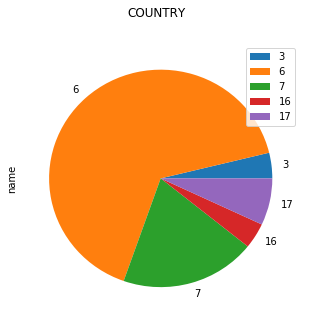

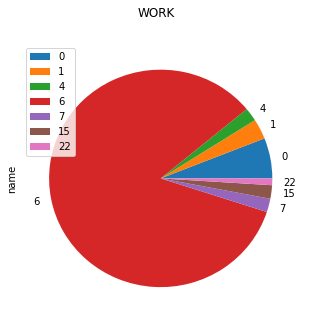

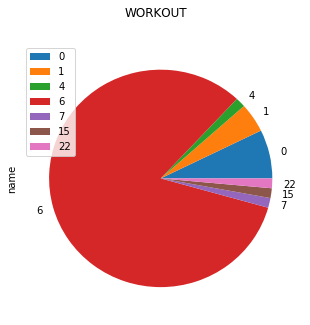

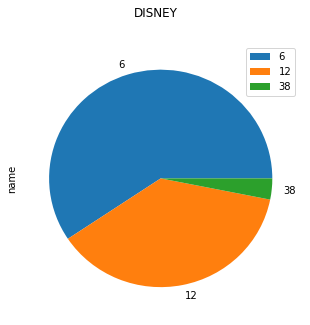

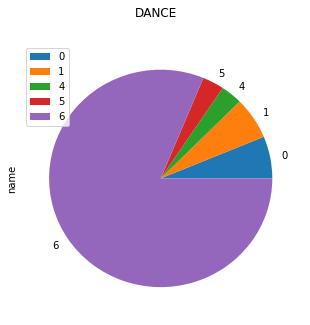

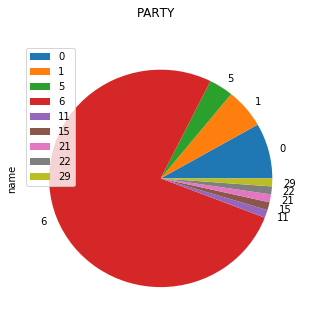

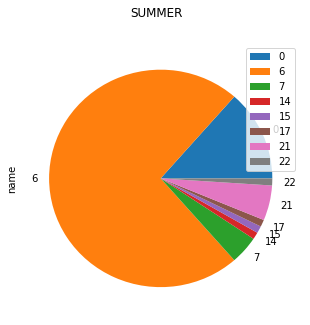

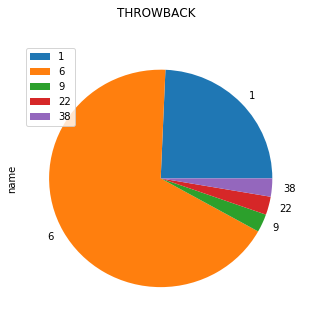

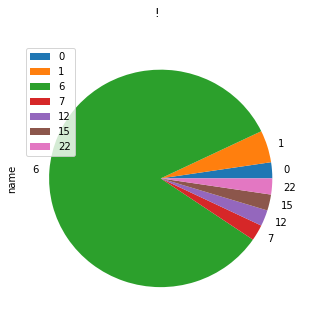

In [121]:
def get_belonging(word):
    _df = clusterized.loc[df_playlist['name'].str.lower().str.contains(word)]
    return _df.groupby(_df['cluster']).count()

for i in ['country', 'work', 'workout', 'disney', 'dance', 'party', 'summer', 'throwback', '!']:
    sums = get_belonging(i)
    sums.plot(kind='pie', subplots=True, figsize=(5, 5), title=i.upper())


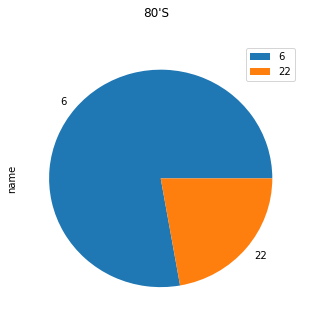

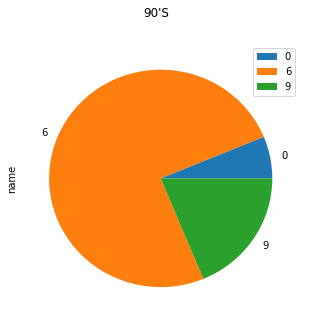

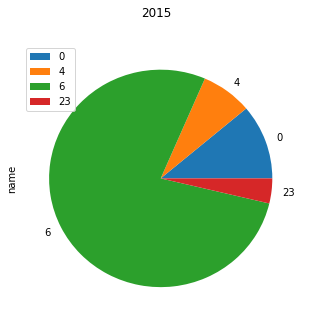

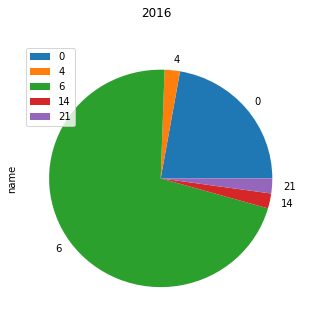

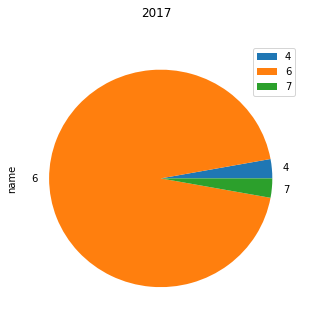

In [122]:
for i in ['80\'s', '90\'s', '2015', '2016', '2017']:
    sums = get_belonging(i)
    sums.plot(kind='pie', subplots=True, figsize=(5, 5), title=i.upper())